# Employing Machine Learning in Security in the Real World

## Developing a simple spam filter example
Spam is any data you don't want to see. It could be part of an email. However, spam also occurs in documents, database, datasets, and all sort of other sources. Most people associate spam with emails and text, but spam could also be an image or an advertisement. The point is that you want to filter out unwanted data to keep machine learning applications safe.

### Starting with simple removal
One of the more important tasks to perform is removing obviously bad data from a file or a group of files. For simplicity, this part of the example relies on a single file with multiple unwanted lines in it. These lines are defined by the word `bad`. However, you could just as easily look for other terms or characters used to create scripts, such as `{` and `}`.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('wordnet')
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def Remove_Lines(filename, target_word):
    useful_lines = []
    with open(filename) as entries:
        while True:
            line = entries.readline()
            if not line:
                break
            if not target_word.upper() in line.upper():
                useful_lines += [line.rstrip()]
    return useful_lines

In [3]:
filename = 'TestAccess.txt'
target = 'bad'

good_data = Remove_Lines(filename, target)
for entry in good_data:
    print(entry)

You've gained access to this file.
This line is good.
And, this line is just sort of OK.
Finally, this line is great!


### Manipulating filtered data
It's essential to know how to manipulate a cleaned dataset so that you can perform analysis on it. For example, seeing a word too often might tell you that there is something wrong with the data. As part of this process, you remove the stop words for the language you're using so that they don't add to the processing time. Stop words don't add value to the output of data manipulation. Creating a matrix of word usage in a dataset is also helpful. The matrix allows you to use other forms of analysis to look for word patterns.

In [4]:
def Remove_Stop_Words(data):
    stop_words = set(stopwords.words('english'))
    new_lines = []
    for line in data:
        words = line.split()
        filtered = [word for word in words 
                    if word.lower() not in stop_words]
        new_lines += [' '.join(filtered)]
    return new_lines

In [5]:
def Create_Dictionary(data):
    all_words = []
    for line in data:
        words = line.split()
        all_words += words
        
    dictionary = Counter(all_words)
    return dictionary

In [6]:
def Extract_Features(data, dictionary):
    features_matrix = np.zeros(
        (len(data),len(dictionary)))
    lineID = 0
    for line in data:
        words = line.split()
        for word in words:
          wordID = 0
          for i,d in enumerate(dictionary):
            if d == word:
              wordID = i
              features_matrix[lineID, wordID] += 1
        lineID += 1
    return features_matrix

In [7]:
filtered = Remove_Stop_Words(good_data)
print(filtered)

word_dict = Create_Dictionary(filtered)
print(word_dict)

word_matrix = Extract_Features(filtered, word_dict)
print(word_matrix)

['gained access file.', 'line good.', 'And, line sort OK.', 'Finally, line great!']
Counter({'line': 3, 'gained': 1, 'access': 1, 'file.': 1, 'good.': 1, 'And,': 1, 'sort': 1, 'OK.': 1, 'Finally,': 1, 'great!': 1})
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]]


### CREATING AN EMAIL FILTER
Looking for spam within a group of emails is one of the tasks that machine learning does well. This example relies on the Ling-spam corpus described at https://www.kaggle.com/mandygu/lingspam-dataset. However, the original dataset is immense, so you instead use a specialized version from the `\lingspam_public\lingspam_public\lemm_stop\` folder, which provides the messages with the stop words already processed and the words normalized using _lemmatization_. The messages in `Email_Train` come from the `part1`, `part2`, and `part3` folders (867 messages total, with 144 spam messages), while the messages in the `Email_Test` folder come from the `part4` folder (289 messages total with 48 spam messages). You can tell which messages contain spam because they start with the letters `spmsg` (for spam message).

In [8]:
train_path = "Email_Train"
train_emails = \
    [os.path.join(train_path, f) for f 
     in os.listdir(train_path)]

test_path = "Email_Test"
test_emails = \
    [os.path.join(test_path, f) for f 
     in os.listdir(test_path)]

def Create_Mail_Dictionary(emails):
    cvec = CountVectorizer(
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b',
        max_features=2000)
    corpus = [open(email).read() for email in emails]
    cvec.fit(corpus)
    return cvec

train_cvec = Create_Mail_Dictionary(train_emails)

In [9]:
def Extract_Mail_Features(emails, cvec):
    corpus = [open(email).read() for email in emails]
    return cvec.transform(corpus)
    
train_feat = Extract_Mail_Features(train_emails, train_cvec)
test_feat = Extract_Mail_Features(test_emails, train_cvec)

In [10]:
train_labels = np.zeros(867)
train_labels[723:867] = 1

test_labels = np.zeros(289)
test_labels[241:289] = 1

MNB = MultinomialNB()
MNB.fit(train_feat, train_labels)

result = MNB.predict(test_feat)
print(confusion_matrix(test_labels, result))

[[239   2]
 [  0  48]]


C:\Users\John\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


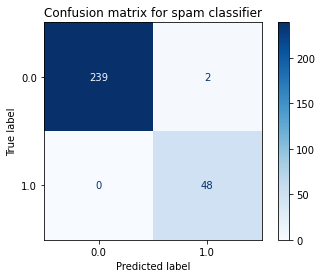

In [11]:
matrix = plot_confusion_matrix(MNB, 
                               X=test_feat, 
                               y_true=test_labels,
                               cmap=plt.cm.Blues) 
plt.title('Confusion matrix for spam classifier')
plt.show(matrix)
plt.show()

This part of the example doesn't actually appear in the book due to space considerations. Think of it as a perk for using the downloadable source. Being able to detect the top words in any corpus is important, but especially so when working with spam because knowing what these words are can help you direct your focus.

In [12]:
top_spam_words = [key for key, value in train_cvec.vocabulary_.items() 
                  if MNB.feature_log_prob_[1, value] > -5]

print(f"{top_spam_words}")

['list', 'send', 'mail', 'address', 'money', 'program', 'receive', 'work', 'email', 'free', 'order', 'business', 'report']


# Stemming versus Lemmatization
There are two common techniques for normalizing words within documents: stemming and lemmatization. Each has its uses. _Stemmming_ simply removes the prefixes and suffixes of words to normalize on root word. For example: player, plays, and playing would all be stemmed to the root word play. This technique is most used for word analysis, such as determining how often particular words appear in one or more documents. _Lemmatization_ processes the words in context, so that the words running, runs, and ran all appear as the root word run. You use this technique most often for text analysis, such as determining the relationships of words in a spam message versus a usable (ham) message.

## Stemming

In [13]:
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize

LS = LancasterStemmer()
print(LS.stem("player"))
print(LS.stem("plays"))
print(LS.stem("playing"))

tokens = word_tokenize("Gary played the player piano while playing cards.")
stemmed = [LS.stem(word) for word in tokens]
print(" ".join(stemmed))

play
play
play
gary play the play piano whil play card .


## Lemmatization

In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

WNL = WordNetLemmatizer()
print(WNL.lemmatize("player", pos="v"))
print(WNL.lemmatize("plays", pos="v"))
print(WNL.lemmatize("playing", pos="v"))

tokens = word_tokenize("Gary played the player piano while playing cards.")
lemmatized = [WNL.lemmatize(word, pos="v") for word in tokens]
print(" ".join(lemmatized))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


player
play
play
Gary play the player piano while play card .
